In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import trange
import pickle
tfb = tfp.bijectors
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

from mydelfi import ndes,mdn

/usr/local/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [54]:
# import data
theta_ = (np.load('/Users/lucas/Datasets/imnn_borg/score_parameters_new.npy').astype(np.float32))
summaries_ = np.load('/Users/lucas/Datasets/imnn_borg/score_vectors_new.npy').astype(np.float32)

#t2 = (np.load('./borg-imnn/regression/regression_theta2_amp.npy').astype(np.float32))
#s2 = np.load('./borg-imnn/regression/regression_x2_amp.npy').astype(np.float32)

max_om = 0.9

mask = theta_[:, 0] < max_om

theta_ = theta_[mask]
summaries_ = summaries_[mask]

#summaries_ = summaries_.reshape(summaries_.shape[0], 4)

weights = np.ones((summaries_.shape[0], 1)).astype(np.float32)


eps = 0.0

# bijector theta -> phi
theta_min = [0.1 - eps, 0.4 - eps]
theta_max = [max_om + eps, 1.6 + eps]
bijector = tfb.Blockwise([tfb.Chain([tfb.Invert(tfb.NormalCDF()), tfb.Scale(np.float32(1./(theta_max[_] - theta_min[_]))), tfb.Shift(-theta_min[_])]) for _ in range(len(theta_min))])

# phi
phi_ = bijector(theta_).numpy()

In [55]:
theta_[:, 0].min()

0.10028441

In [56]:
theta_.shape, summaries_.shape, phi_.shape

((5000, 2), (5000, 2), (5000, 2))

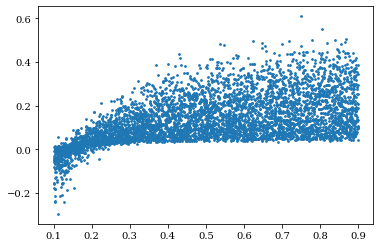

In [57]:
plt.scatter(theta_[:, 0], (summaries_[:, 0]), s=3)
#plt.axvline(0.27, color='k')
plt.show()

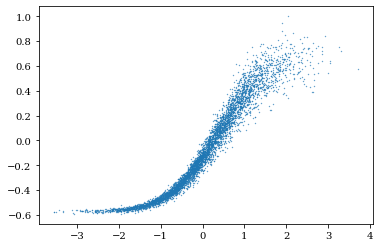

In [58]:
plt.scatter(phi_[:,1], (summaries_[:,1]), s=0.1)
plt.show()

In [59]:
theta = tf.convert_to_tensor(theta_, dtype=tf.float32)
phi   = tf.convert_to_tensor(phi_, dtype=tf.float32)
weights = tf.convert_to_tensor(weights, dtype=tf.float32)
summaries = tf.convert_to_tensor(summaries_, dtype=tf.float32)

In [60]:
pwd

'/Users/lucas/repositories/alfi_lensing/defli'

In [61]:
# Amortized posterior
filename = './amortized_post_moped_pk_new'
AmortizedPosterior = mdn.MixtureDensityNetwork2(n_components=3, 
                            n_conditionals=2, 
                            n_dimensions=2, 
                            optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                            n_hidden=[50, 50],
                            activation=[tf.tanh, tf.tanh])

In [62]:
#AmortizedPosterior.optimizer = tf.keras.optimizers.Adam(lr=1e-4)
historyAP = AmortizedPosterior.fit(training_conditionals=summaries, training_variables=phi, training_weights=weights, 
                        epochs=3000, batch_size=100, patience=200, save=True, filename=filename)

 49%|████▉     | 1467/3000 [03:10<03:19,  7.69it/s, training loss=1.11, validation_loss=1.18] 


KeyboardInterrupt: 

In [63]:
# reload best model
AmortizedPosterior = mdn.MixtureDensityNetwork2(n_components=6, 
                            n_conditionals=2, 
                            n_dimensions=2, 
                            optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                            n_hidden=[50, 100],
                            activation=[tf.tanh, tf.tanh],
                            restore=True,
                            restore_filename=filename)

In [67]:
summaries_obs = np.squeeze(np.load("/Users/lucas/Datasets/imnn_borg/score_estimates_new.npy")) #np.array([0.3215735 , 0.75502646]).astype(np.float32) #  [0.30336806, 0.7549215 ]

In [68]:
# plot over a grid
omegaM = np.linspace(0.11, 0.9, 70)
sigma8 = np.linspace(0.41, 1.6, 110)
OM, S8 = np.meshgrid(omegaM, sigma8)
theta_grid = np.concatenate([OM[...,np.newaxis], S8[...,np.newaxis]], axis=-1)
phi_grid = bijector(theta_grid)

cond_shape = theta_grid.shape[:-1] + (2,)

log_prob = tf.squeeze(AmortizedPosterior.log_prob(phi_grid, conditional=summaries_obs*np.ones(cond_shape).astype(np.float32))).numpy()
#log_prob = SamplingDistribution.log_prob(summaries_obs*np.ones(phi_grid.shape).astype(np.float32), conditional=theta_grid).numpy()
log_prob = log_prob - max(log_prob.flatten())

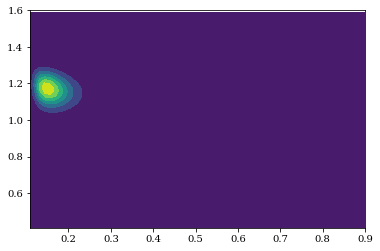

In [69]:
plt.contourf(omegaM, sigma8, np.exp(log_prob))
plt.show()

In [70]:
np.std(theta[:,0])

0.23190154

In [71]:
Posterior = AmortizedPosterior.distribution(summaries_obs[np.newaxis, :].astype(np.float32))

posterior_samples = bijector.inverse(Posterior.sample(100000)).numpy()
cut = np.all(~np.isinf(posterior_samples), axis=-1)
posterior_samples = posterior_samples[cut,:]


# cut = posterior_samples[:, 0] < 0.8
# posterior_samples = posterior_samples[cut, :]

# cut = posterior_samples[:, 0] > 0.1
# posterior_samples = posterior_samples[cut, :]

(array([6.2883e+04, 3.2444e+04, 4.0720e+03, 4.5500e+02, 9.9000e+01,
        2.7000e+01, 9.0000e+00, 8.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([0.10184387, 0.16022237, 0.21860087, 0.2769794 , 0.33535787,
        0.3937364 , 0.45211488, 0.5104934 , 0.5688719 , 0.6272504 ,
        0.6856289 ], dtype=float32),
 <BarContainer object of 10 artists>)

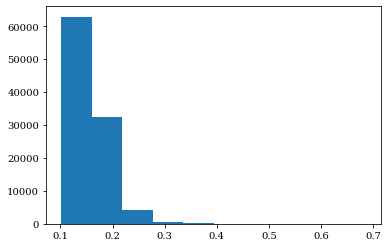

In [72]:
plt.hist(posterior_samples[:, 0])

In [73]:
import numpy as np
import h5py as h5
import matplotlib.pylab as plt
from scipy.stats import gaussian_kde

def get_data_borg(f,start):
    A1 = f['A1']
    bTA = f['bTA']
    A2 = f['A2']
    omegaM = f['omegaM']
    sigma8 = f['sigma8']
    h100 = f['h']
    return A1[start:], bTA[start:], A2[start:], omegaM[start:], h100[start:], sigma8[start:]

In [74]:
omegaM,sigma8,h100 = np.load("/Users/lucas/repositories/IMNN_vs_BORG/posterior_plots/borg_posterio_twoparam.npy").T



g = np.load('/Users/lucas/repositories/IMNN_vs_BORG/borg_runs_fixed_IA_fixed_h.npz')
A1,bTA,A2,omegaM,h100,sigma8 = get_data_borg(g,0)

omegaM_cls, s8_cls, *_ = np.load("/Users/lucas/repositories/IMNN_vs_BORG/samples_noIA.npy").T


F_moped_pk = np.array([[227.42737 , 106.132576],
       [106.13046 , 816.0338  ]])

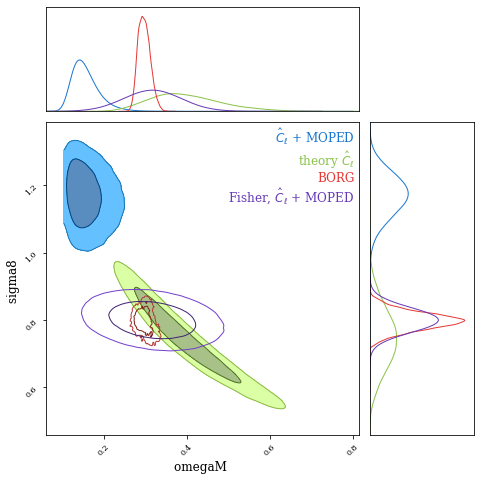

In [75]:
from chainconsumer import ChainConsumer

_psts = posterior_samples.copy()
#_psts[:, 0] = 0.3*(posterior_samples[:, 0]**2 / posterior_samples[:, 1]**2)

cs = ChainConsumer()
cs.add_chain(_psts, parameters=['omegaM', 'sigma8'], name=r'$\hat{C}_\ell$ + MOPED') #, color=corner_colors[0])

cs.add_chain(np.stack([omegaM_cls, s8_cls], -1), parameters=['omegaM', 'sigma8'], name=r'theory $\hat{C}_\ell$') #, color=corner_colors[0])

cs.add_chain(np.stack([omegaM, sigma8], axis=-1), parameters=['omegaM', 'sigma8'], name='BORG')

cs.add_covariance(mean=np.array([0.3175, 0.8]), covariance=np.linalg.inv(F_moped_pk), parameters=['omegaM', 'sigma8'],
                  name=r"Fisher, $\hat{C}_\ell$ + MOPED")

cs.configure(linestyles=["-", "-", "-", "-"], linewidths=[1.0, 1.0, 1.0, 1.0], usetex=False,
        shade=[True, True, True, False], shade_alpha=[0.7, 0.6, 0., 0.], tick_font_size=8, sigma2d=False)
cs.plotter.plot((7,7))
plt.show()

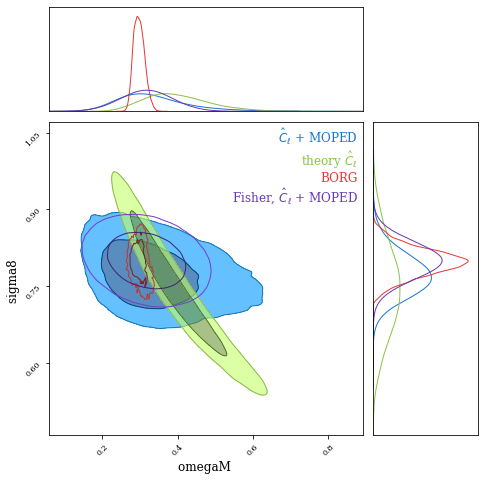

In [30]:
from chainconsumer import ChainConsumer

_psts = posterior_samples.copy()
#_psts[:, 0] = 0.3*(posterior_samples[:, 0]**2 / posterior_samples[:, 1]**2)

cs = ChainConsumer()
cs.add_chain(_psts, parameters=['omegaM', 'sigma8'], name=r'$\hat{C}_\ell$ + MOPED') #, color=corner_colors[0])

cs.add_chain(np.stack([omegaM_cls, s8_cls], -1), parameters=['omegaM', 'sigma8'], name=r'theory $\hat{C}_\ell$') #, color=corner_colors[0])

cs.add_chain(np.stack([omegaM, sigma8], axis=-1), parameters=['omegaM', 'sigma8'], name='BORG')

cs.add_covariance(mean=np.array([0.3175, 0.8]), covariance=np.linalg.inv(F_moped_pk), parameters=['omegaM', 'sigma8'],
                  name=r"Fisher, $\hat{C}_\ell$ + MOPED")

cs.configure(linestyles=["-", "-", "-", "-"], linewidths=[1.0, 1.0, 1.0, 1.0], usetex=False,
        shade=[True, True, True, False], shade_alpha=[0.7, 0.6, 0., 0.], tick_font_size=8, sigma2d=False)
cs.plotter.plot((7,7))
plt.show()

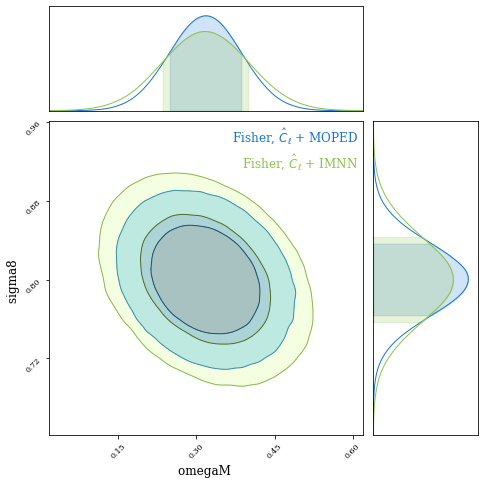

In [35]:
F_imnn_pk = np.array([[162.17816,  91.07747],
       [ 91.07748, 593.42993]])


cs = ChainConsumer()


cs.add_covariance(mean=np.array([0.3175, 0.8]), covariance=np.linalg.inv(F_moped_pk), parameters=['omegaM', 'sigma8'],
                  name=r"Fisher, $\hat{C}_\ell$ + MOPED")

cs.add_covariance(mean=np.array([0.3175, 0.8]), covariance=np.linalg.inv(F_imnn_pk), parameters=['omegaM', 'sigma8'],
                  name=r"Fisher, $\hat{C}_\ell$ + IMNN")

cs.configure(linestyles=["-", "-", "-", "-"], linewidths=[1.0, 1.0, 1.0, 1.0], usetex=False,
        shade=[True, True, True, False], shade_alpha=[0.3, 0.2, 0., 0.], tick_font_size=8, sigma2d=False)

cs.plotter.plot((7,7))
plt.show()

In [ ]:
np.save('./pk_moped_posterior_samples', posterior_samples)

# now set up PIT coverage tests

for every pair (theta*, data*) in the training set, for each of the marginals compute P(theta < theta* | data*), and plot the distribution of those cumulative probabilities

In [28]:
from tqdm import tqdm

In [29]:
omegam_cdfs = []
sigma8_cdfs = []

for i in tqdm(range(5000)):
  theta_i = theta_[i]
  summary_i = summaries_[i]
  # could add tfp mixture model here for more than one MDN
  # p(theta | x)
  dist = AmortizedPosterior.distribution(summary_i[np.newaxis, :].astype(np.float32))
  
  samps = bijector.inverse(dist.sample(100000)).numpy()
  cut = np.all(~np.isinf(samps), axis=-1)
  samps = samps[cut,:]
  norm = samps.shape[0]


  #for each marginal
  omegam_cdfs.append(np.sum(samps[:, 0] <= theta_i[0]) / norm) 
  sigma8_cdfs.append(np.sum(samps[:, 1] <= theta_i[1]) / norm)

  #plt.hist(samps[:, 1])
  #plt.axvline(theta_i[:, 1])
  
  

 50%|█████     | 2516/5000 [03:06<03:04, 13.46it/s]


KeyboardInterrupt: 

In [30]:
bins = 20
nsamps = len(omegam_cdfs)

uniform_layer = nsamps / bins
std = np.sqrt(uniform_layer)

Text(0.5, 0, '$\\sigma_8$-PIT')

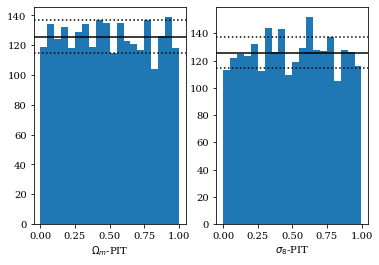

In [31]:
plt.subplot(121)
plt.hist(omegam_cdfs, bins=bins, density=False)
plt.axhline(uniform_layer, color='k')
plt.axhline(uniform_layer - std, color='k', ls=':')
plt.axhline(uniform_layer + std, color='k', ls=':')

plt.xlabel(r'$\Omega_m$-PIT')

plt.subplot(122)
plt.hist(sigma8_cdfs, bins=bins, density=False)
plt.axhline(uniform_layer, color='k')

plt.axhline(uniform_layer - std, color='k', ls=':')
plt.axhline(uniform_layer + std, color='k', ls=':')

plt.xlabel(r'$\sigma_8$-PIT')